# Предсказываем спрос на аренду велосипедов

https://www.kaggle.com/c/bike-sharing-demand

Системы совместного использования велосипедов - это средство аренды велосипедов, где процесс получения членства, аренды и возврата велосипедов автоматизирован через сеть киосков по всему городу. Используя эти системы, люди могут арендовать велосипед из одного места и возвращать его в другое место по мере необходимости. В настоящее время в мире действует более 500 программ обмена велосипедами.

Данные, сгенерированные этими системами, делают их привлекательными для исследователей, поскольку продолжительность поездки, место отправления, место прибытия и истекшее время явно записаны. Поэтому системы совместного использования велосипедов функционируют как сенсорная сеть, которую можно использовать для изучения мобильности в городе. В этом конкурсе участников просят объединить исторические модели использования с данными о погоде, чтобы прогнозировать спрос на аренду велосипедов в рамках программы Capital Bikeshare в Вашингтоне, округ Колумбия.

Тренировочный набор состоит из первых 19 дней каждого месяца, а тестовый набор - с 20-го по конец месяца.


# Задача 

Спрогнозировать общее количество велосипедов, арендованных в течение каждого часа, покрываемого тестовым набором, используя только информацию, доступную до периода проката.

# Описание датасета:

Параметры:

datetime - почасовая дата + отметка времени

season - 1 = весна, 2 = лето, 3 = осень, 4 = зима

holiday - считается ли день праздником

workingday - будь то выходной или праздничный день

weather - 1: Ясно, Облачно, Небольшая Облачность

2: Туман + Облачно, Туман + Разбитые облака, Туман + Немного облаков, Туман

3: легкий снег, легкий дождь + гроза + рассеянные облака, легкий дождь + рассеянные облака

4: сильный дождь + ледяные поддоны + гроза + туман, снег + туман

temp - температура в градусах Цельсия

atemp - "ощущается как" температура в градусах Цельсия

humidity - относительная влажность

windspeed - скорость ветра

casual - количество инициированных прокатов незарегистрированных пользователей

registered - количество зарегистрированных арендованных пользователей

count - количество всех арендных плат

# Туториал

#### 1) Скачаем необходимые для работы библиотеки

        a) numpy - расширение языка Python, добавляющее поддержку больших многомерных массивов и матриц, вместе с большой библиотекой высокоуровневых математических функций для операций с этими массивами
        б) pandas - различные структуры данных и анализ
        в) pydot
        г) sklearn - С помощью нее можно реализовать различные алгоритмы классификации, регрессии и кластеризации, в том числе алгоритмы SVM, случайного леса, k-ближайших соседей и DBSCAN, которые построены на взаимодействии библиотек NumPy и SciPy с Python.
        д) matplotlib - библиотека на языке программирования Python для визуализации данных двумерной (2D) графикой (3D графика также поддерживается)
        е) seaborn - это библиотека визуализации данных Python, основанная на matplotlib.

In [1]:
import numpy as np
import pandas as pd
import pydot as p
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics, pipeline, preprocessing
from sklearn.ensemble import RandomForestRegressor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [99]:
import warnings
warnings.filterwarnings('ignore')

#### 2) Скачаем необходимые данные и исследуем их начальное состояние

In [161]:
#импорт датасета
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
submission = pd.read_csv('sampleSubmission.csv')

In [3]:
#вывод первых пяти строк трейновой выборки
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
#вывод первых пяти строк тестовой выборки
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
# Выводим статистику для train по значениям признаков: 
# среднее, стандартное отклонение, минимальное и максимальное значения, квартили
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
# Выводим статистику для test по значениям признаков: 
# среднее, стандартное отклонение, минимальное и максимальное значения, квартили
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [7]:
# узнаем по каждому параметру кол-во переменных, их формат и есть ли пустые значения.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
# узнаем по каждому параметру кол-во переменных, их формат и есть ли пустые значения.
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [9]:
# узнаем кол-во иследуемых объектов и кол-во оцениваемых признаков
train.shape

(10886, 12)

In [10]:
# узнаем кол-во иследуемых объектов и кол-во оцениваемых признаков
test.shape

(6493, 9)

In [11]:
# Проверка на пропущенные данные
train.isnull().any().any()

False

In [12]:
# Проверка на пропущенные данные
test.isnull().any().any()

False

#### Выводы: 
          1) Нет пропущенных значений по всем признакам
          2) В train есть 3 target переменных (casual, registered, count) 
          3) После обучения моделей на train.csv сделаем прогноз для тестовой выборки test.csv

#### 3) Чтобы лучше разобраться в данных, визуализируем их с помощью библиотеки matplotlib, отдельно выделим таргет переменную count

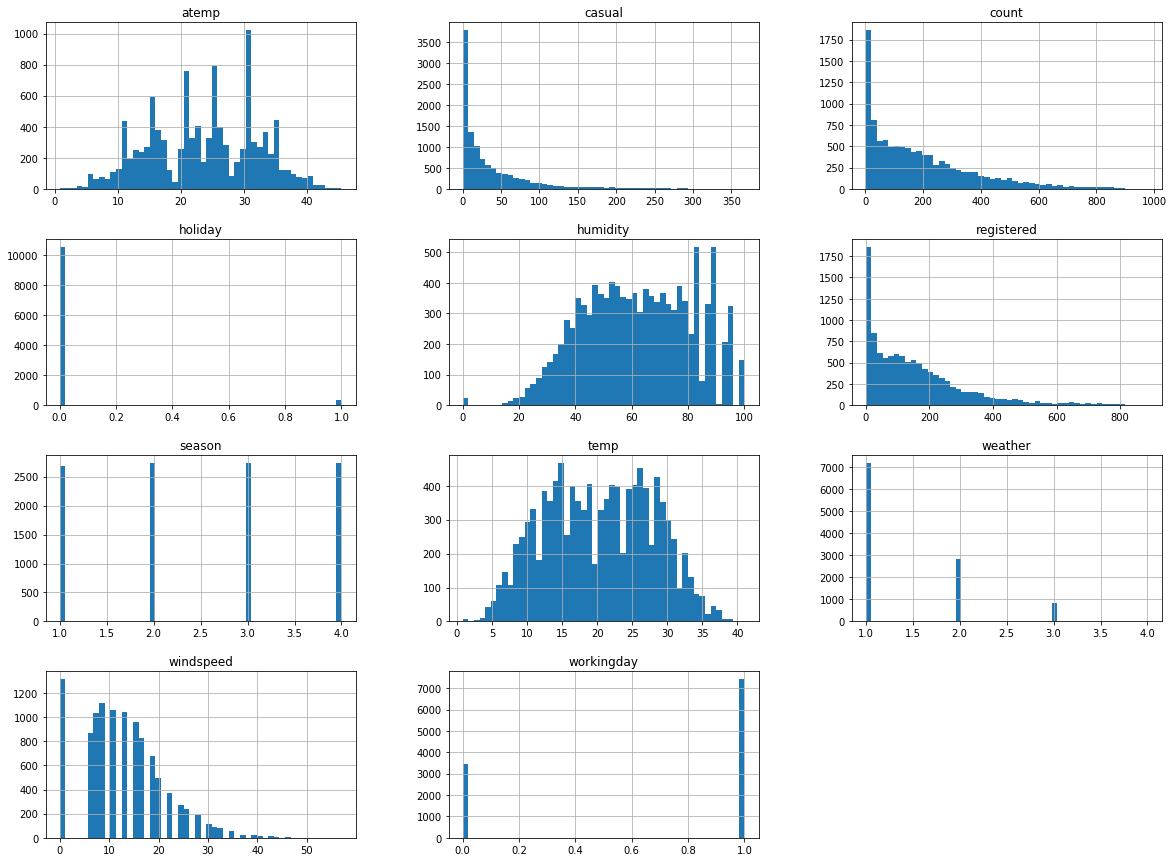

In [13]:
# визуализация данных
train.hist(bins=50, figsize=(20,15))
plt.show()

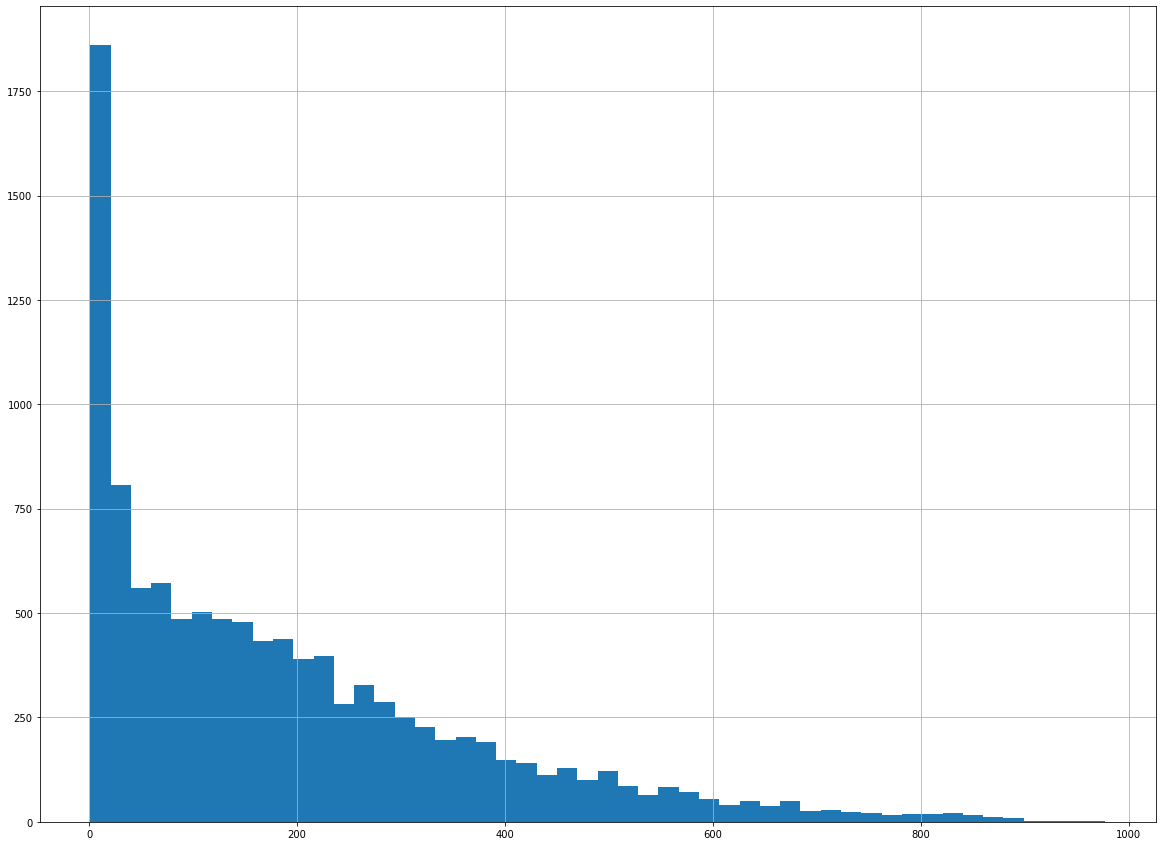

In [14]:
train['count'].hist(bins=50, figsize=(20,15))

#### 4) Рассмотрим корреляцию между нашими параметрами

В математической статистике корреляция — понятие, которым отмечают связь между явлениями, если одно из них входит в число причин, определяющих другие, или если имеются общие причины, воздействующие на эти явления (функция является частным случаем корреляции); корреляция может быть более или менее тесной (т. е. зависимость одной величины от другой — более или менее ясно выраженной); число, показывающее степень тесноты корреляции, называется коэффициентом корреляции (это число заключено между -1 и 1);

1 - положительная корреляция -1 - отрицательная корреляция 0 - не коррелируют

В pandas есть 3 метода для функции corr



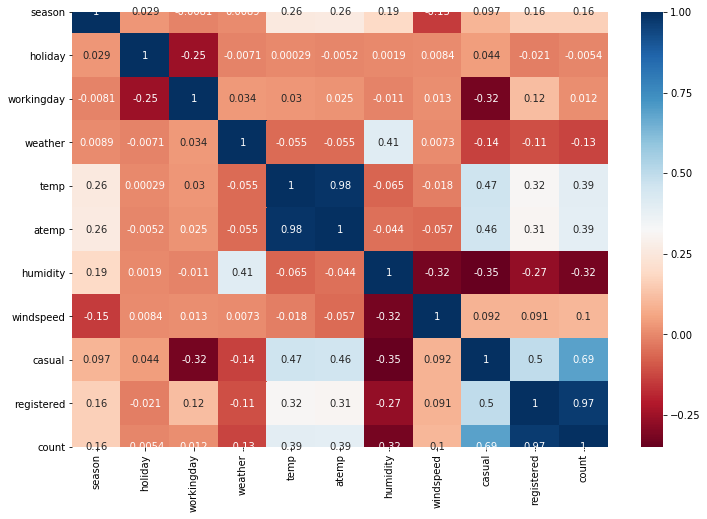

In [15]:
#pearson : standard correlation coefficient - стандартный коэффициент корреляции 
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="pearson"), annot =True, cmap='RdBu')
plt.show()

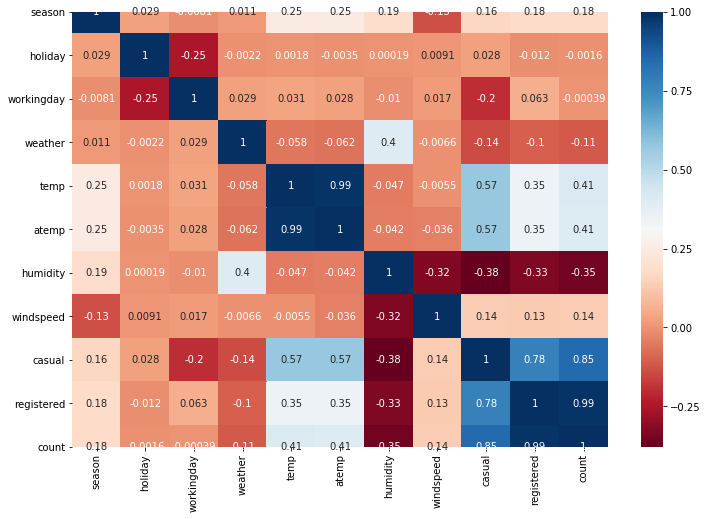

In [16]:
# spearman : Spearman rank correlation - Коэффициент ранговой корреляции Спирмена
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="spearman"), annot =True, cmap='RdBu')
plt.show()

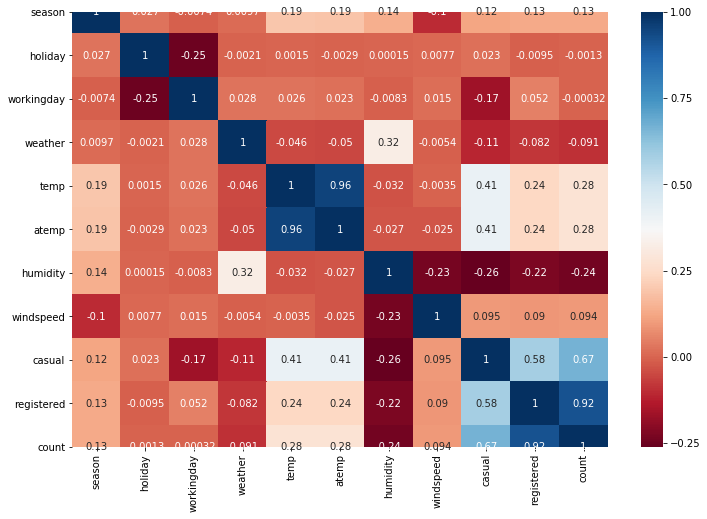

In [17]:
# kendall : Kendall Tau correlation coefficient - Коэффициент ранговой корреляции Кендалла
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="kendall"), annot =True, cmap='RdBu')
plt.show()

#### 4) Перейдем к обработке наших данных. 
У нас есть параметр datetime, разделим его на число, месяц, час, день недели.
Теперь давайте рассмотрим как влияет день недели на кол-во арендаторов.


In [162]:
# делим datetime на параметры
train.datetime = train.datetime.apply(pd.to_datetime)
train['month'] = train.datetime.apply(lambda x : x.month)
train['hour'] = train.datetime.apply(lambda x : x.hour)
train['date'] = train.datetime.apply(lambda x : x.day)
train['weekday'] = train.datetime.apply(lambda x : x.weekday())
train.head(400)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,date,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,1,0,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,1,2,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,1,3,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,4,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2011-01-17 23:00:00,1,1,0,3,6.56,6.820,86,19.0012,1,3,4,1,23,17,0
396,2011-01-18 12:00:00,1,0,1,2,8.20,9.090,86,22.0028,0,3,3,1,12,18,1
397,2011-01-18 13:00:00,1,0,1,2,8.20,9.850,86,15.0013,0,22,22,1,13,18,1
398,2011-01-18 14:00:00,1,0,1,2,9.02,11.365,80,11.0014,2,26,28,1,14,18,1


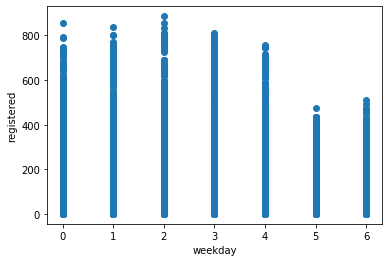

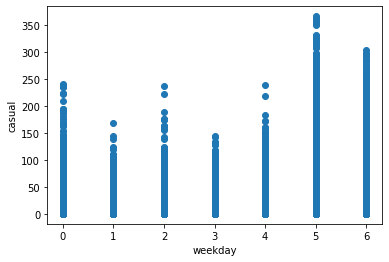

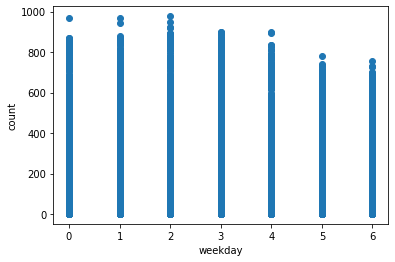

In [19]:
# статистика по дням недели для зарегестрированных пользователей
plt.scatter(train['weekday'], train['registered'])
plt.xlabel('weekday')
plt.ylabel('registered')
plt.show()
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['casual'])
plt.xlabel('weekday')
plt.ylabel('casual')
plt.show()
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['count'])
plt.xlabel('weekday')
plt.ylabel('count')
plt.show()

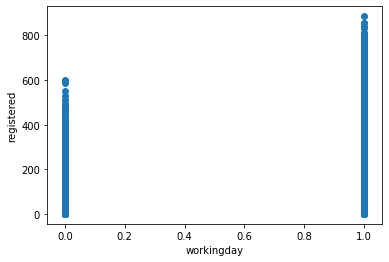

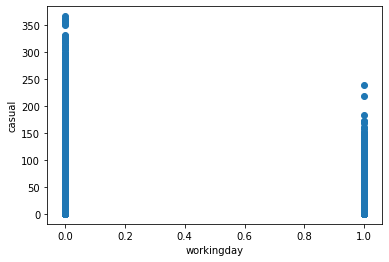

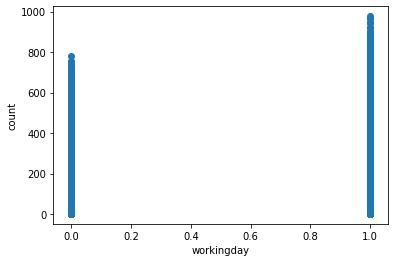

In [20]:
# статистика по рабочим/выходным дням недели для зарегестрированных пользователей
plt.scatter(train['workingday'], train['registered'])
plt.xlabel('workingday')
plt.ylabel('registered')
plt.show()
# статистика по рабочим/выходным дням недели для не зарегестрированных пользователей
plt.scatter(train['workingday'], train['casual'])
plt.xlabel('workingday')
plt.ylabel('casual')
plt.show()
# статистика по рабочим/выходным дням недели для всех пользователей
plt.scatter(train['workingday'], train['count'])
plt.xlabel('workingday')
plt.ylabel('count')
plt.show()

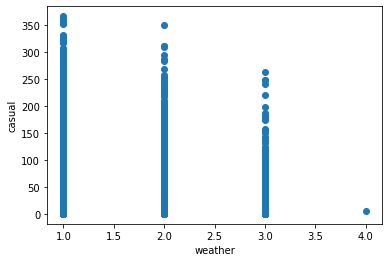

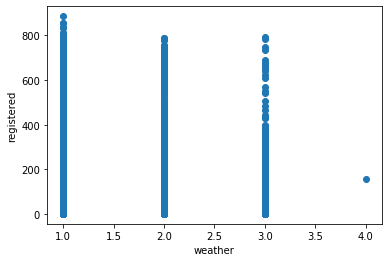

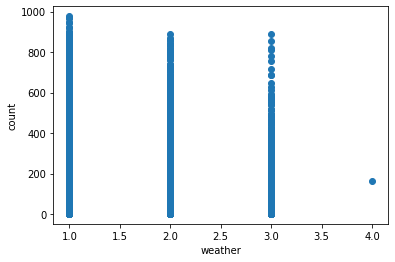

In [21]:
# статистика по погоде для незарегистрированных пользователей
plt.scatter(train['weather'], train['casual'])
plt.xlabel('weather')
plt.ylabel('casual')
plt.show()

# статистика по погоде для зарегистрированных пользователей
plt.scatter(train['weather'], train['registered'])
plt.xlabel('weather')
plt.ylabel('registered')
plt.show()

# статистика по погоде для всех пользователей
plt.scatter(train['weather'], train['count'])
plt.xlabel('weather')
plt.ylabel('count')
plt.show()

Отметим что данные являются ли пользователи зарегистрированными или нет не влияют на таргет переменную, поэтому удалим столбцы registered и casual, также признаки workingday и weekday имеют схожий смысл, поэтому можем удалить один из них.

In [163]:
train = train.drop(['datetime'], axis = 1);

In [164]:
 train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,date,weekday
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,1,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2,1,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3,1,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4,1,5


 В таблице X оставим необходимые для изучения данных параметры, в таблице Y - один столбик содержащий таргет переменную

In [165]:
# X = train.drop(['datetime','weekday','count', 'casual', 'registered'], axis = 1)
X = train.drop(['count', 'casual', 'registered'], axis = 1)
Y = train['count'].values

In [166]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y)

## Регрессия

In [89]:
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [141]:
# Выпишем модели регрессси, которые хотим использовать
regressions = {}
regressions["LinearRegression"] = LinearRegression()
regressions["Ridge"]  = Ridge()
regressions["RidgeCV"]   = RidgeCV()
regressions["ElasticNet"]  = ElasticNet()
# regressions["Lars"]  = Lars()
regressions["Lasso"]  = Lasso()
regressions["AdaBoostRegressor"] = AdaBoostRegressor()
regressions["BaggingRegressor"] = BaggingRegressor()
regressions["ExtraTreesRegressor"] = ExtraTreesRegressor()
regressions["GradientBoostingRegressor"]  = GradientBoostingRegressor()
regressions["RandomForestRegressor"]    = RandomForestRegressor()
regressions["DecisionTreeRegressor"]    = DecisionTreeRegressor()

In [167]:
regResult = []
models = []
for name in regressions:
    model = regressions[name]
    res = cross_val_score(model, train_data, train_labels)
    regResult.append(res)
    models.append(name)
    print("{}: {}, {}".format(name, round(res.mean(), 3), round(res.std(), 3)))

LinearRegression: 0.338, 0.016
Ridge: 0.338, 0.016
RidgeCV: 0.339, 0.016
ElasticNet: 0.339, 0.016
Lasso: 0.339, 0.016
AdaBoostRegressor: 0.578, 0.015
BaggingRegressor: 0.847, 0.003
ExtraTreesRegressor: 0.845, 0.005
GradientBoostingRegressor: 0.796, 0.001
RandomForestRegressor: 0.842, 0.005
DecisionTreeRegressor: 0.729, 0.003


## LinearRegression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
Обычная наименьших квадратов линейная регрессия.

LinearRegression соответствует линейной модели с коэффициентами w = (w1,…, wp), чтобы минимизировать остаточную сумму квадратов между наблюдаемыми целями в наборе данных и целями, прогнозируемыми линейным приближением.

In [67]:
resultLR = cross_val_score(LinearRegression(), train_data, train_labels)
print(resultLR)

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.34251506 0.34511476 0.33040408]


## Ridge

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge


In [78]:
resultRiR = cross_val_score(Ridge(), train_data, train_labels)
print(resultRiR)

[0.34251344 0.34511726 0.33040734]


C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


## RidgeCV
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

In [81]:
resultRiCVR = cross_val_score(RidgeCV(), train_data, train_labels)
print(resultRiCVR)

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.34249937 0.34513749 0.33043544]


## ElasticNet

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

In [82]:
resultENR = cross_val_score(ElasticNet(), train_data, train_labels)
print(resultENR)

[0.34249937 0.34513749 0.33043544]


C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


## Lars

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html#sklearn.linear_model.Lars

In [84]:
resultLR = cross_val_score(Lars(), train_data, train_labels)
print(resultLR)

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.34251506 0.34511476 0.33040408]


## Lasso

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

In [87]:
resultLaR = cross_val_score(Lasso(), train_data, train_labels)
print(resultLaR)

[0.34245312 0.34501495 0.33108415]


C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


## AdaBoostRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor

In [88]:
resultABR = cross_val_score(AdaBoostRegressor(), train_data, train_labels)
print(resultABR)

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.59276183 0.62044297 0.58260839]


## BaggingRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor

In [90]:
resultBR = cross_val_score(BaggingRegressor(), train_data, train_labels)
print(resultBR)

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.82439632 0.84251644 0.83831123]


## ExtraTreesRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor

In [91]:
resultETR = cross_val_score(ExtraTreesRegressor(), train_data, train_labels)
print(resultETR)

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.84119601 0.84882042 0.84503172]


## GradientBoostingRegressor
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

In [92]:
resultGBR = cross_val_score(GradientBoostingRegressor(), train_data, train_labels)
print(resultETR)

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.84119601 0.84882042 0.84503172]


## RandomForestRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

In [ ]:
resultRFR = cross_val_score(RandomForestRegressor(), train_data, train_labels)
print(resultRFR)

## DecisionTreeRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor


In [75]:
resultDTR = cross_val_score(DecisionTreeRegressor(), train_data, train_labels)
print(resultDTR)

[0.68242235 0.72620801 0.71804148]


C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [168]:
# выделяем бинарные данные
binary_columns = ['holiday', 'workingday']
binary_indices = np.array([(column in binary_columns) for column in X.columns], dtype = bool)
# выделяем категориальные данные
categorical_columns = ['season', 'weather', 'month', 'date', 'weekday']
categorical_indieces = np.array([(column in  categorical_columns) for column in X.columns], dtype = bool)
# выделяем интервальные данные
numeric_columns = ['temp', 'atepm', 'humidity', 'windspeed', 'hour']
numeric_indices = np.array([(column in numeric_columns) for column in X.columns], dtype = bool)


# regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 200)
estimators = {}
for name in regressions:
    model = regressions[name]
    estimator = pipeline.Pipeline(steps = [
    ('feature_processing0', pipeline.FeatureUnion(transformer_list = [
        ('binary_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_indices], validate = True)),
        
        ('numeric_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean = 0.))
                ])),
        
        ('categorical_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_indieces])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
                ])),
    ])),
    ('model_fitting', model)
    ])
    estimators[name] = estimator;
   
    

# обработка данных
# estimator = pipeline.Pipeline(steps = [
#     ('feature_processing0', pipeline.FeatureUnion(transformer_list = [
#         ('binary_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_indices], validate = True)),
        
#         ('numeric_processing', pipeline.Pipeline(steps = [
#             ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_indices])),
#             ('scaling', preprocessing.StandardScaler(with_mean = 0.))
#                 ])),
        
#         ('categorical_processing', pipeline.Pipeline(steps = [
#             ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_indieces])),
#             ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
#                 ])),
#     ])),
#     ('model_fitting', regressor)
#     ]
# )

In [144]:
print(estimators)

{'LinearRegression': Pipeline(memory=None,
         steps=[('feature_processing0',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x0000022BE2749798>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=True)),
                                                ('numeric_processing',
   

In [169]:
for name in estimators:
    estimators[name].fit(np.array(train_data), train_labels)
    print("{}: {}, {}".format(name, estimators[name].score(train_data, train_labels), metrics.mean_absolute_error(test_labels, estimators[name].predict(np.array(test_data)))))

LinearRegression: 0.36160475911139023, 108.2096056278215
Ridge: 0.3615990572966078, 108.21058016616931
RidgeCV: 0.36154933258206867, 108.19898173866214
ElasticNet: 0.3114782709517808, 113.57981899580963
Lasso: 0.3558907397267663, 108.24442252504814
AdaBoostRegressor: 0.6147422883480715, 89.02623257745773
BaggingRegressor: 0.9736478369524261, 45.148567229977964
ExtraTreesRegressor: 1.0, 45.44107274063189
GradientBoostingRegressor: 0.8065706430729932, 57.1146066821942
RandomForestRegressor: 0.9742522483911984, 44.03078618662747
DecisionTreeRegressor: 1.0, 56.46399706098457


In [128]:
# estimator.score(train_data, train_labels)

0.9775667236384107

In [129]:
# metrics.mean_absolute_error(test_labels, estimator.predict(np.array(test_data)))

44.671910543559186

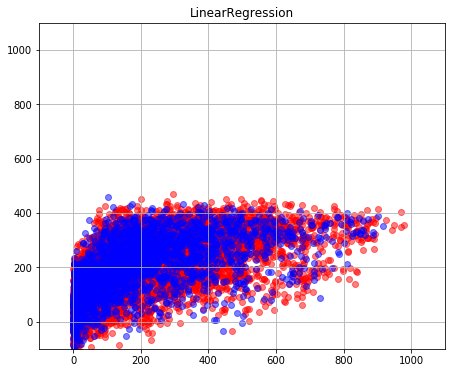

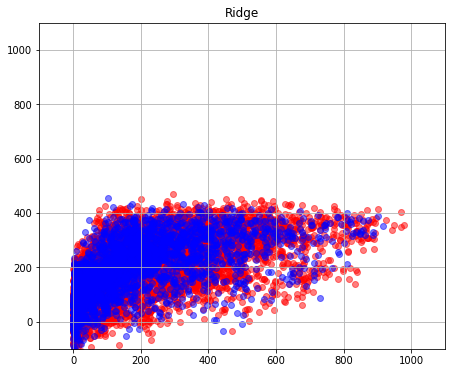

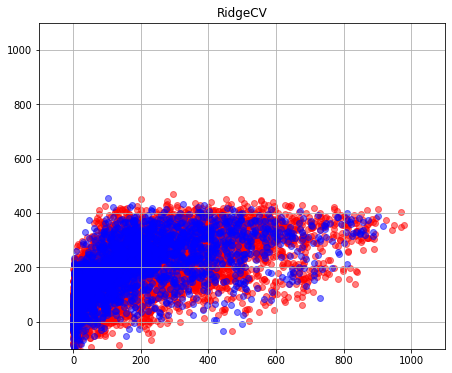

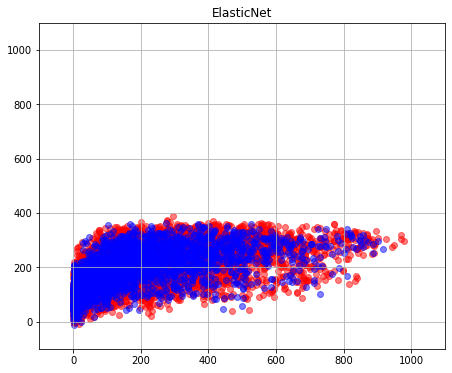

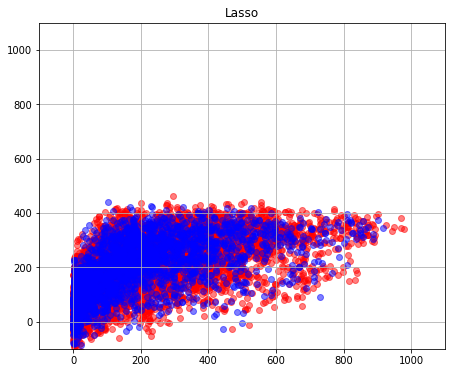

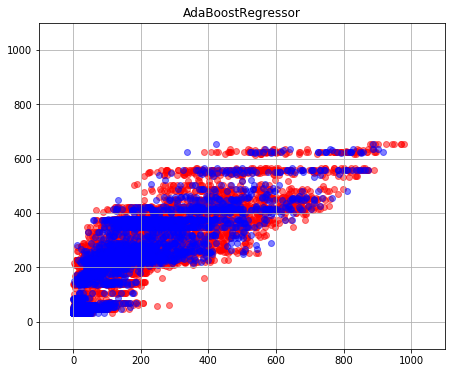

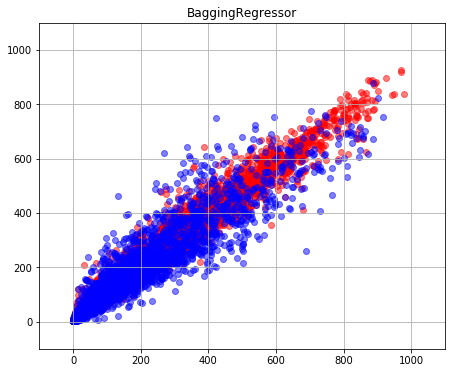

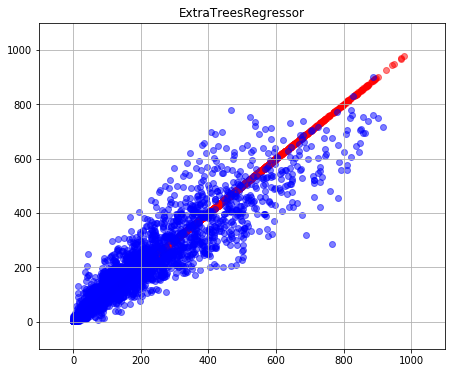

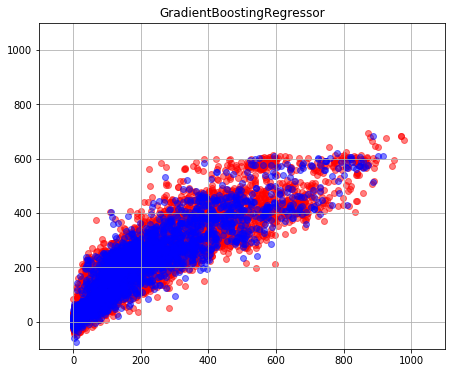

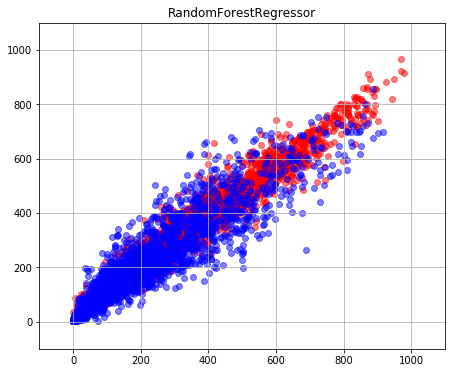

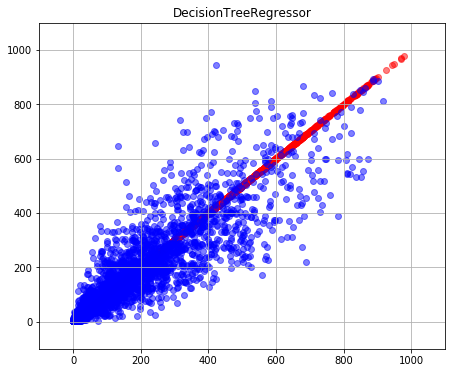

In [170]:
for name in estimators:
    pylab.figure(figsize = (16, 6))
    pylab.subplot(1, 2, 2)
    pylab.grid(True)
    pylab.xlim(-100, 1100)
    pylab.ylim(-100, 1100)
    pylab.scatter(train_labels, estimators[name].predict(np.array(train_data)), alpha = 0.5, color = 'red')
    pylab.scatter(test_labels, estimators[name].predict(np.array(test_data)), alpha = 0.5, color = 'blue')
    pylab.title(name)

Если график похож на диагональный, то он хороший
по горизонтали - предикт?
по веркали - на самом деле
Bagging
Extra
Random
Desition

In [173]:
# вывод предсказанных значений и настоящих 
print(test_labels[:10])
for name in estimators:
    print((estimators[name].predict(np.array(test_data)))[:10])

[119  89 274 120  29 492 120 123 347 603]
[213.09648179 150.13984006 377.80742637 166.66964521 161.88111549
 142.18230076 130.19802441 289.74678057 333.44050471 305.04033199]
[212.98018096 150.22495995 377.68207169 167.02564576 162.20702333
 142.35582984 129.98547492 289.35989965 333.41421942 305.17973935]
[212.56568742 150.32566833 376.45002016 167.17171915 162.50303688
 142.13757699 129.64415392 288.11725501 333.44340279 305.03199536]
[209.3144125  173.51030731 283.64899978 193.07662386 191.17150892
 147.47845776 143.99802867 236.86312895 301.92363605 268.00659848]
[212.55194886 146.53380925 348.1158045  177.31375412 174.31053898
 134.82742341 118.32684128 266.01886737 332.19415968 300.38371744]
[215.679893   259.94423159 364.23315393 215.43913043 172.86633663
 363.0223198  221.30445545 330.87808808 448.91059888 413.36077058]
[116.8  62.8 231.4 131.   23.6 373.5 128.9 141.3 601.4 606.3]
[174.6  94.1 220.7 139.9  21.2 457.6  87.  143.3 622.1 600.8]
[134.0954037   52.44381359 265.04512

In [174]:
result = pd.read_csv('test.csv', header = 0, sep = ',')
result.datetime = result.datetime.apply(pd.to_datetime)
result['month'] = result.datetime.apply(lambda x : x.month)
result['hour'] = result.datetime.apply(lambda x : x.hour)
result['date'] = result.datetime.apply(lambda x : x.day)
result['weekday'] = result.datetime.apply(lambda x : x.weekday())
output = result
output = output.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'date', 'weekday'], axis = 1)
result = result.drop(['datetime'], axis = 1)


predictions = estimators['RandomForestRegressor'].predict(np.array(result))
output = pd.read_csv('sampleSubmission.csv', header = 0, sep = ',')
output['count'] = predictions
output.to_csv('sampleSubmissionRandomForest.csv', index=False)
output.head()

,datetime,count
0,2011-01-20 00:00:00,11.3
1,2011-01-20 01:00:00,4.7
2,2011-01-20 02:00:00,5.1
3,2011-01-20 03:00:00,3.1
4,2011-01-20 04:00:00,2.9
